# Particle Tracking with Steaming (based on .HDF5 file)

This notebook provides an example for;
    1. tracking particle position from an image sequence
    2. linking positions to construct particle's trajectory
    3. filtering spurious trajectories
    4. drift calculation and drift subtraction
    5. msd calculation



## Image sequence

In [1]:
import pims
import trackpy as tp
import matplotlib.pyplot as plt
import progressbar
import tpstream as tps

In [2]:
frames = pims.ImageSequence("video_test_stream/*.tif")

Frame([[ 9,  9,  9, ...,  7,  9,  9],
       [ 9,  9,  8, ...,  8,  8,  8],
       [ 9,  9,  7, ...,  7,  8,  7],
       ..., 
       [ 9,  9, 10, ...,  9,  9,  7],
       [10, 10,  9, ...,  8,  8,  9],
       [ 9, 10,  9, ...,  7,  8,  9]], dtype=uint8)
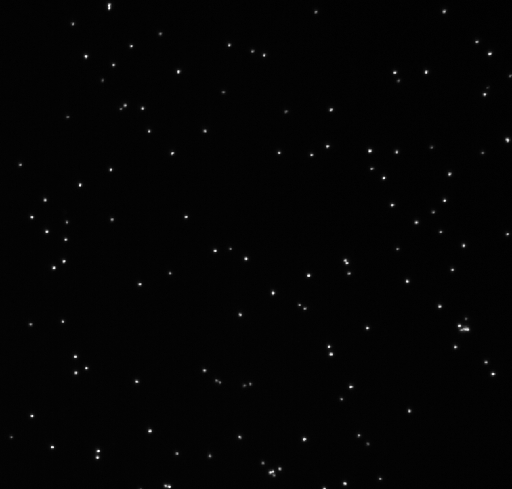

In [3]:
frames[671]

## Locate features

In [5]:
maxact = 8 # number of activity in the exp
size = 11 # estimate particle size in pixel (diameter)
mm = 300 # minmass
maxdis = 6 # max displacement
mem = 10 # allow particle to disappear for some period
#Nframes = 2000 # no. of frames per one activity
threshold = 1

In [6]:
f = tp.locate(frames[0], size, minmass=mm, smoothing_size = 7, threshold = threshold,percentile=0, separation = 3, characterize = True) # 'look for bright' position, number indicates size of particle (in pixel)

In [12]:
f.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,502.250177,4.277032,1024.013784,2.185561,0.123621,63.684249,2248.0,0.011639,0
1,397.193759,11.299347,1994.474903,2.118325,0.030823,117.960598,3798.0,0.005798,0
2,645.960733,26.756254,2488.027836,2.179082,0.094892,141.118507,4586.0,0.004619,0
3,169.819874,34.223186,4588.160698,2.764551,0.299869,158.486939,8535.0,0.002288,0
4,106.413293,34.578852,1197.698100,2.196262,0.119867,70.197411,2553.0,0.009713,0


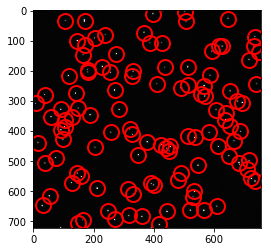

In [7]:
plt.figure()  # make a new fi
tp.annotate(f, frames[0]); 

In [8]:
!rm -f test_position.h5

In [10]:
pro = progressbar.ProgressBar(len(frames))
with tp.PandasHDFStoreSingleNode("test_position.h5") as p:  # This opens an HDF5 file. Data will be stored and retrieved by frame number.
    for i ,frame in enumerate(frames):
        features = tp.locate(frame, size, minmass= 300, smoothing_size = 7, threshold = 1, separation = 3)  # Find the features in a given frame.
        features.drop(features.columns[[5,6,7]], axis = 1, inplace = True) # drop [signal, raw_mass, ep]
        p.put(features)
        pro.animate(i)

# Linking positions

In [11]:
!rm -f test_traj.h5

In [12]:
with tp.PandasHDFStoreSingleNode("test_position.h5") as p:
    with tp.PandasHDFStoreSingleNode("test_traj.h5") as traj:
        for i, linked in enumerate(tp.link_df_iter(p, search_range = 6, memory=10)):
            linked.particle = linked.particle.astype(int) # change to int, for more convenient
            traj.put(linked)                                                           

Frame 800: 115 trajectories present


In [13]:
with tp.PandasHDFStoreSingleNode("test_traj.h5") as traj:
    traj_frame = traj.get(0)

In [14]:
traj_frame.head()

,x,y,mass,size,ecc,frame,particle
0,502.250177,4.277032,1024.013784,2.185561,0.123621,0,0
1,397.193759,11.299347,1994.474903,2.118325,0.030823,0,1
2,645.960733,26.756254,2488.027836,2.179082,0.094892,0,2
3,169.819874,34.223186,4588.160698,2.764551,0.299869,0,3
4,106.413293,34.578852,1197.698100,2.196262,0.119867,0,4


In [15]:
import plots_trackpy

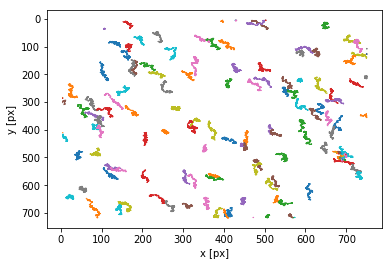

In [16]:
plots_trackpy.plot_traj_stream("test_traj.h5")

## Remove trajectories which are too short

In [17]:
tps.filter_stubs("test_traj.h5", "test_traj2.h5", threshold = 30)

1/2 Find trajectories length
2/2 Save to a new file
Before: 159
After: 124


# Filter spurious trajectories

Based on particle properties such as mass, size and ecc.

In [20]:
char_av = tps.par_char("test_traj2.h5")

In [21]:
char_av.head()

,mass,size,ecc,particle
1,2169.143283,2.115946,0.079661,1.0
2,2186.429381,2.189428,0.105600,2.0
3,4243.118048,2.820473,0.349534,3.0
4,1299.871740,2.132688,0.060130,4.0
5,1926.695051,2.118671,0.090611,5.0


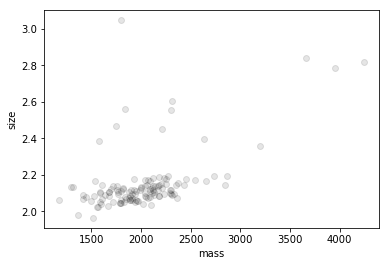

In [26]:
plt.figure()
tp.mass_size(char_av)

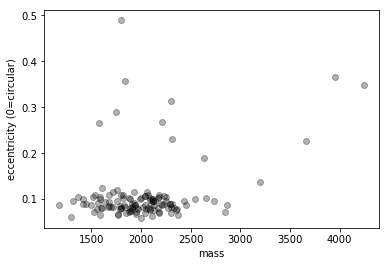

In [27]:
plt.figure()
tp.mass_ecc(char_av)

In [28]:
p = char_av[((char_av.mass > 3000) | (char_av.size > 2.3) & (char_av.ecc > 0.15))]

1. Aggregation: high mass
2. Pt ships: low mass, high size and ecc

In [29]:
p.head()

,mass,size,ecc,particle
3,4243.118048,2.820473,0.349534,3.0
64,3956.074114,2.784372,0.366477,64.0
81,2632.080017,2.398876,0.189620,81.0
96,1803.729932,3.047179,0.489488,96.0
119,2313.254808,2.606995,0.231465,119.0


In [30]:
pindices = list(p.particle.values.astype(int))

In [31]:
pindices

[3, 64, 81, 96, 119, 121, 126, 137, 141, 146, 149, 155]

In [32]:
tps.filter_index("test_traj2.h5","test_traj3.h5", pindices)

Before: 124
After: 112


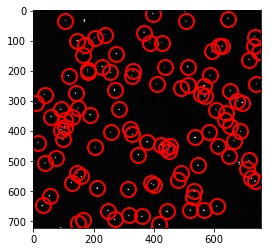

In [47]:
with tp.PandasHDFStoreSingleNode("test_traj3.h5") as traj:
    f = traj.get(0)
plt.figure()  # make a new fi
tp.annotate(f, frames[0]); 

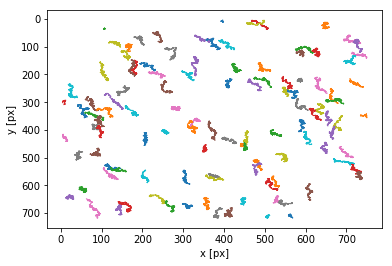

In [51]:
plt.figure()
plots_trackpy.plot_traj_stream("test_traj3.h5")

## Drift calculation + substraction

In [34]:
drift = tps.compute_drift("test_traj3.h5", smoothing= 5)

Drift calc


/data2/Ong/test python/examples/sand box Trackpy/tpstream.py:251: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False,min_periods=0).mean()
  dx = pd.rolling_mean(dx, smoothing, min_periods=0)


In [35]:
drift.head()

,x,y
0,0.000000,0.000000
1,0.003767,0.021419
2,-0.016149,0.047673
3,-0.040819,0.058532
4,-0.059087,0.083547


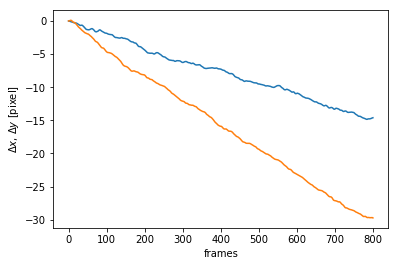

In [57]:
plt.figure()
plt.plot(drift)
plt.xlabel('frames')
plt.ylabel('$\Delta x$, $\Delta y$ [pixel]')
plt.show()

In [59]:
tps.subtract_drift("test_traj3.h5", "test_traj_final.h5", drift)

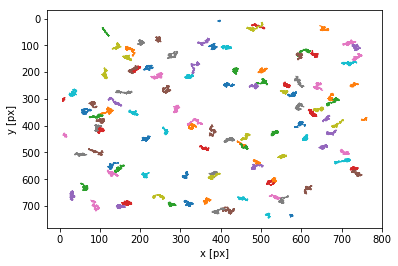

In [61]:
plt.figure()
plots_trackpy.plot_traj_stream("test_traj_final.h5")

## MSD

In [62]:
mpp = 0.273 # micron per pixel
fps = 20 # frames per second
nlagtime = 100 # number of estimated required lagtime
max_lagtime = 200 # maximum intercals of frames

In [64]:
em = tps.emsd("test_traj_final.h5", mpp, fps, nlagtime, max_lagtime, framejump = 10)

In [65]:
em.head()

,<x^2>,<y^2>,msd,std,lagt
1,0.0153699,0.0150842,0.0304541,0.003172,0.05
2,0.03779,0.0363417,0.0741316,0.00660258,0.10
3,0.0589809,0.0567403,0.115721,0.0108302,0.15
4,0.0798106,0.0768682,0.156679,0.0138742,0.20
5,0.100175,0.09626,0.196435,0.0180922,0.25


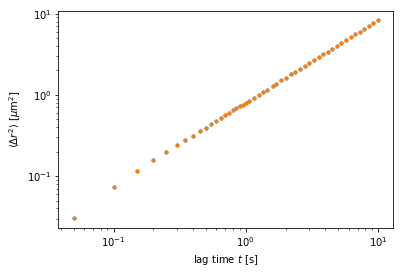

In [67]:
plt.plot(em.lagt,em.msd,'.')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$ [s]')
plt.xscale('log')
plt.yscale('log')
plt.show()

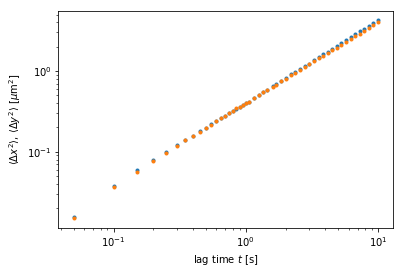

In [68]:
x = plt.plot(em.lagt,em['<x^2>'],'.')
y = plt.plot(em.lagt,em['<y^2>'],'.')
plt.ylabel(r'$\langle \Delta x^2 \rangle$, $\langle \Delta y^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$ [s]')
plt.xscale('log')
plt.yscale('log')
plt.show()